In [1]:
from PIL import Image, ImageFont, ImageDraw, ImageFilter
from PIL.ImageChops import add, subtract, multiply, difference, screen
import PIL.ImageStat as stat
import matplotlib.image as mpimg
import matplotlib.pylab as plt
import matplotlib.pyplot as plot
import numpy as np
import cv2
import sys
from skimage.io import imread, imsave, imshow
from skimage import color, data, exposure, img_as_float, io
from skimage.color import rgb2gray
from skimage.transform import swirl
from sklearn.cluster import KMeans


img_file = "coffee.png"

In [2]:
def get_pixel(image, i, j):
    width, height = image.size
    if i > width or j > height:
        return None
    
    pixel = image.getpixel((i, j))
    return pixel

In [3]:
def get_saturation(value, quadrant):
    if value > 223:
        return 255
    elif value > 159:
        if quadrant != 1:
            return 255

        return 0
    elif value > 95:
        if quadrant == 0 or quadrant == 3:
            return 255

        return 0
    elif value > 32:
        if quadrant == 1:
            return 255

        return 0
    else:
        return 0

In [4]:
def plot_img_and_hist(image, axes, bins=256):
    image = img_as_float(image)
    ax_img, ax_hist = axes
    
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    return ax_img, ax_hist

# **Reading, Displaying, and Saving an Image**

(400, 600, 3) float32 <class 'numpy.ndarray'>


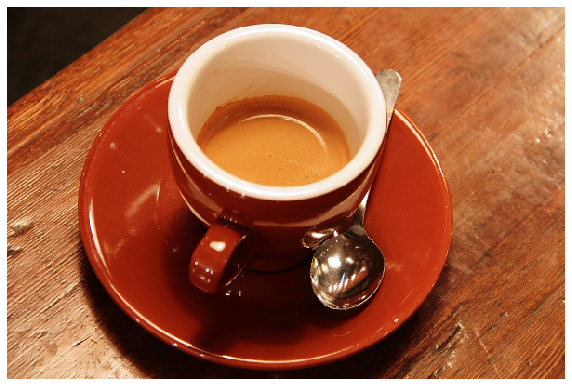

In [5]:
im = mpimg.imread(img_file) # read the image from disk as a numpy ndarray
print(im.shape, im.dtype, type(im))
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis('off')
plt.show()

plt.imshow(im)
plt.axis('off')
plt.tight_layout()
plt.savefig("coffee_saved.png")
plt.close()

# **Image Sampling**

In [6]:
image = Image.open(img_file)

width, height = image.size

new_img = Image.new("RGB", (width*2, height*2), "white")
new_pixel = new_img.load()
old_pixel = image.load()

m = 0
n = 0

for i in range(0, width):
    for j in range(0, height):
        new_pixel[m,n]  = old_pixel[i,j]
        new_pixel[m, n+1]  = old_pixel[i,j]
        new_pixel[m+1, n]  = old_pixel[i,j] 
        new_pixel[m+1, n+1]  = old_pixel[i,j]
        n += 2
    m += 2
    n = 0
    
new_img.save("coffee_sampling_2x.png")

# **Image Quantization**

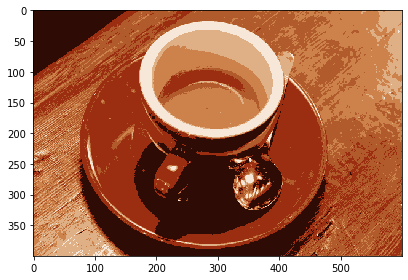

In [7]:
original = io.imread(img_file)
n_colors = 6

arr = original.reshape((-1, 3))
kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
less_colors = centers[labels].reshape(original.shape).astype('uint8')

io.imshow(less_colors)

imsave("coffee_lesscolors.png", less_colors)

# **Image Dithering**

(-0.5, 599.5, 399.5, -0.5)

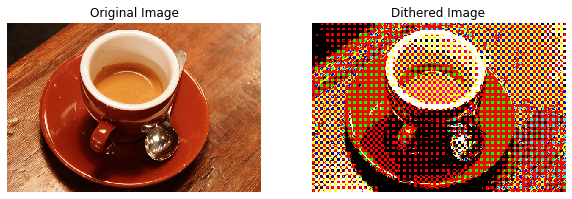

In [8]:
image = Image.open(img_file)

width, height = image.size

new_img = Image.new("RGB", (width,height), "white")

pixels = new_img.load()

for i in range(0, width, 2):
    for j in range(0, height, 2):
        p1 = get_pixel(image, i, j)
        p2 = get_pixel(image, i, j + 1)
        p3 = get_pixel(image, i + 1, j)
        p4 = get_pixel(image, i + 1, j + 1)
        red   = (p1[0] + p2[0] + p3[0] + p4[0]) / 4
        green = (p1[1] + p2[1] + p3[1] + p4[1]) / 4
        blue  = (p1[2] + p2[2] + p3[2] + p4[2]) / 4

        r = [0, 0, 0, 0]
        g = [0, 0, 0, 0]
        b = [0, 0, 0, 0]

        for x in range(0, 4):
            r[x] = get_saturation(red, x)
            g[x] = get_saturation(green, x)
            b[x] = get_saturation(blue, x)

        pixels[i, j]         = (r[0], g[0], b[0])
        pixels[i, j + 1]     = (r[1], g[1], b[1])
        pixels[i + 1, j]     = (r[2], g[2], b[2])
        pixels[i + 1, j + 1] = (r[3], g[3], b[3])


new_img.save("coffee_dithering.png")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 8))
ax0.imshow(image)
ax0.set_title("Original Image")
ax0.axis('off')
ax1.imshow(new_img)
ax1.set_title("Dithered Image")
ax1.axis('off')

# **Halftoning**

(-0.5, 599.5, 399.5, -0.5)

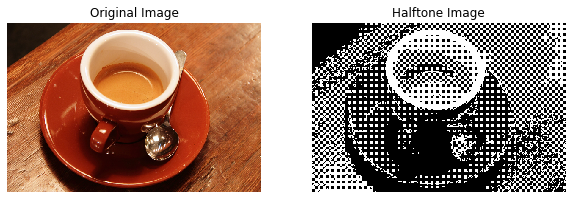

In [10]:
image = Image.open(img_file)

width, height = image.size

new_img = Image.new("RGB", (width, height), "white")
pixels = new_img.load()

for i in range(0, width, 2):
    for j in range(0, height, 2):
        p1 = get_pixel(image, i, j)
        p2 = get_pixel(image, i, j + 1)
        p3 = get_pixel(image, i + 1, j)
        p4 = get_pixel(image, i + 1, j + 1)

        gray1 = (p1[0] * 0.299) + (p1[1] * 0.587) + (p1[2] * 0.114)
        gray2 = (p2[0] * 0.299) + (p2[1] * 0.587) + (p2[2] * 0.114)
        gray3 = (p3[0] * 0.299) + (p3[1] * 0.587) + (p3[2] * 0.114)
        gray4 = (p4[0] * 0.299) + (p4[1] * 0.587) + (p4[2] * 0.114)

        sat = (gray1 + gray2 + gray3 + gray4) / 4

        if sat > 223:
            pixels[i, j]         = (255, 255, 255) # White
            pixels[i, j + 1]     = (255, 255, 255) # White
            pixels[i + 1, j]     = (255, 255, 255) # White
            pixels[i + 1, j + 1] = (255, 255, 255) # White
        elif sat > 159:
            pixels[i, j]         = (255, 255, 255) # White
            pixels[i, j + 1]     = (0, 0, 0)       # Black
            pixels[i + 1, j]     = (255, 255, 255) # White
            pixels[i + 1, j + 1] = (255, 255, 255) # White
        elif sat > 95:
            pixels[i, j]         = (255, 255, 255) # White
            pixels[i, j + 1]     = (0, 0, 0)       # Black
            pixels[i + 1, j]     = (0, 0, 0)       # Black
            pixels[i + 1, j + 1] = (255, 255, 255) # White
        elif sat > 32:
            pixels[i, j]         = (0, 0, 0)       # Black
            pixels[i, j + 1]     = (255, 255, 255) # White
            pixels[i + 1, j]     = (0, 0, 0)       # Black
            pixels[i + 1, j + 1] = (0, 0, 0)       # Black
        else:
            pixels[i, j]         = (0, 0, 0)       # Black
            pixels[i, j + 1]     = (0, 0, 0)       # Black
            pixels[i + 1, j]     = (0, 0, 0)       # Black
            pixels[i + 1, j + 1] = (0, 0, 0)       # Black

new_img.save("coffee_halftoned.png")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 8))
ax0.imshow(image)
ax0.set_title("Original Image")
ax0.axis('off')
ax1.imshow(new_img)
ax1.set_title("Halftone Image")
ax1.axis('off')

# **Split Red, Green, Blue Channels**

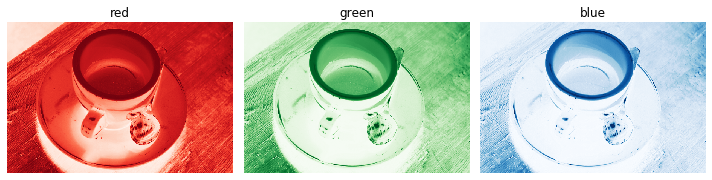

In [11]:
image = Image.open(img_file)
red_channel, green_channel, blue_channel = image.split()
plt.figure(figsize=(10,8))

plt.subplot(1,3,1)
plt.imshow(red_channel, cmap=plt.cm.Reds)
plt.axis('off')
plt.title("red")
plt.subplot(1,3,2)
plt.imshow(green_channel, cmap=plt.cm.Greens)
plt.axis('off')
plt.title("green")
plt.subplot(1,3,3)
plt.imshow(blue_channel, cmap=plt.cm.Blues)
plt.axis('off')
plt.title("blue")

plt.tight_layout()
plt.show()

# **Convert RGB to HSV Color Space**

C:\Anaconda\lib\site-packages\skimage\io\_io.py:141: UserWarning: coffee_hsv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


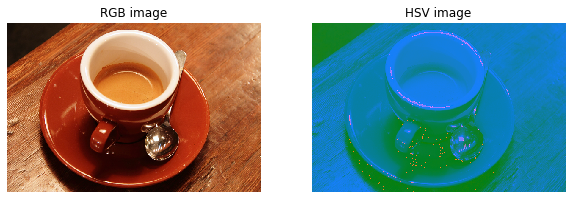

In [12]:
rgb_img = imread(img_file)
hsv_img = color.rgb2hsv(rgb_img)
hsv_img[:, :, 1] = 0.5

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 8))
ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hsv_img, cmap='hsv')
ax1.set_title("HSV image")
ax1.axis('off')

imsave('coffee_hsv.png', hsv_img)

# **Convert RGB to Grayscale**

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


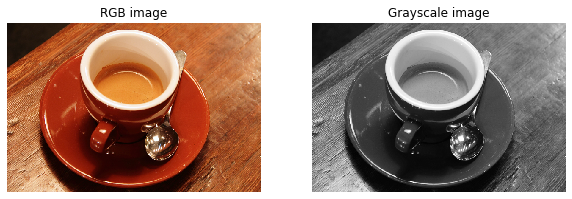

In [13]:
rgb_img = imread(img_file)
gray_img = rgb2gray(rgb_img)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 8))
ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(gray_img, cmap=plt.cm.gray)
ax1.set_title("Grayscale image")
ax1.axis('off')

imsave('coffee_grayscale.png', gray_img)

# **Convert One Color Space to Another**

<Figure size 432x288 with 0 Axes>

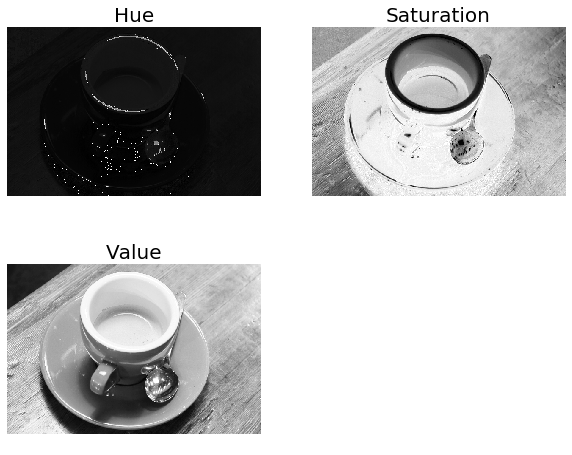

In [14]:
rgb_img = imread(img_file)
hsv_img = color.rgb2hsv(rgb_img)
plt.gray()

plt.figure(figsize=(10,8))
plt.subplot(221), plt.imshow(hsv_img[...,0]), plt.title('Hue', size=20),
plt.axis('off')
plt.subplot(222), plt.imshow(hsv_img[...,1]), plt.title('Saturation', size=20),
plt.axis('off')
plt.subplot(223), plt.imshow(hsv_img[...,2]), plt.title('Value', size=20),
plt.axis('off')
plt.subplot(224), plt.axis('off')
plt.show()

# **Zoom In 3x on Image**

In [16]:
image = Image.open(img_file)

width, height = image.size

new_img = Image.new("RGB", (width*3, height*3), "white")
new_pixel = new_img.load()
old_pixel = image.load()

m = 0
n = 0

for i in range(0, width):
    for j in range(0, height):
        new_pixel[m,n]  = old_pixel[i,j]
        new_pixel[m, n+1]  = old_pixel[i,j]
        new_pixel[m, n+2]  = old_pixel[i,j]
        new_pixel[m+1, n]  = old_pixel[i,j] 
        new_pixel[m+1, n+1]  = old_pixel[i,j]
        new_pixel[m+1, n+2]  = old_pixel[i,j]
        new_pixel[m+2, n]  = old_pixel[i,j] 
        new_pixel[m+2, n+1]  = old_pixel[i,j]
        new_pixel[m+2, n+2]  = old_pixel[i,j]
        n += 3
    m += 3
    n = 0
    
new_img.save("coffee_zoomin.png")

# **Cut and Paste on Image**

(-0.5, 599.5, 399.5, -0.5)

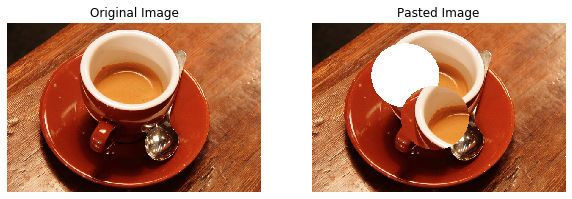

In [17]:
im1 = Image.open(img_file)
im2 = Image.open(img_file)

mask_img = Image.new("L", im2.size, 0)
draw = ImageDraw.Draw(mask_img)
draw.ellipse((140, 50, 300, 200), fill=255)
mask_img.save('mask_circle.jpg', quality=95)
circle = Image.open("mask_circle.jpg")

new_img = im1.copy()
new_img.paste(circle, (0, 0), mask_img)
new_img.paste(im2, (70, 100), mask_img)
new_img.save('coffee_mask_circle_paste.png', quality=95)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 8))
ax0.imshow(im1)
ax0.set_title("Original Image")
ax0.axis('off')
ax1.imshow(new_img)
ax1.set_title("Pasted Image")
ax1.axis('off')

# **Warping an Image by Applying Swirl Transform**

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(-0.5, 599.5, 399.5, -0.5)

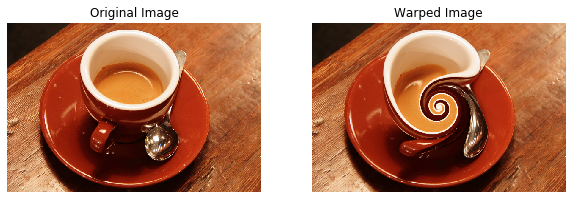

In [18]:
im = imread(img_file)
swirled = swirl(im, rotation=0, strength=15, radius=200)
imsave("coffee_swirl.png", swirled)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 8))
ax0.imshow(im)
ax0.set_title("Original Image")
ax0.axis('off')
ax1.imshow(swirled)
ax1.set_title("Warped Image")
ax1.axis('off')

# **Rotate an Image**

(-0.5, 399.5, 599.5, -0.5)

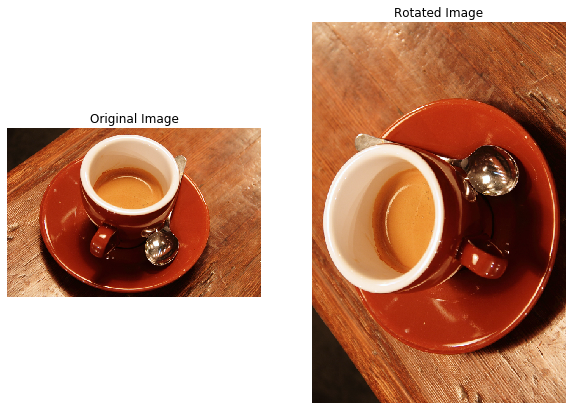

In [19]:
image = Image.open(img_file)

new_img = Image.new("RGB", (image.height, image.width), "white")
new_pixel = new_img.load()
old_pixel = image.load()

width,size = image.size


k = width - 1
    
for i in range(0, width):
    for j in range(0, height):
        new_pixel[j ,k]  = old_pixel[i,j]
    k = k -1

new_img.save("coffee_rotate.png")
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 8))
ax0.imshow(image)
ax0.set_title("Original Image")
ax0.axis('off')
ax1.imshow(new_img)
ax1.set_title("Rotated Image")
ax1.axis('off')

# **RGB Histogram per Channel**

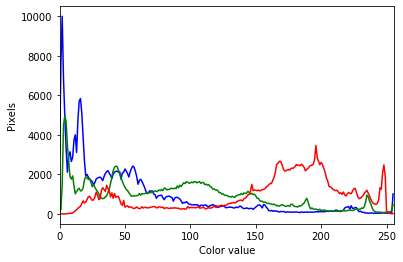

In [20]:
img = cv2.imread(img_file)
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

plt.xlabel("Color value")
plt.ylabel("Pixels")
plt.show()

# **Grayscale Histogram**

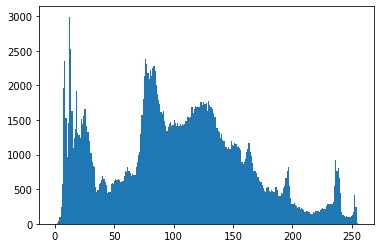

In [21]:
img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
plt.hist(img.ravel(),256,[0,256]); plt.show()

# **Equalization Histogram**

C:\Anaconda\lib\site-packages\skimage\exposure\exposure.py:124: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


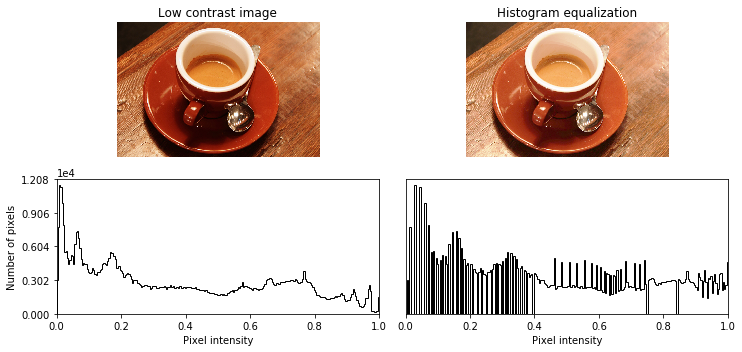

In [22]:
img = imread(img_file)

img_eq = exposure.equalize_hist(img)

fig = plt.figure(figsize=(20, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 2):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 2):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist = plot_img_and_hist(img_eq, axes[:, 1])
ax_img.set_title('Histogram equalization')

fig.tight_layout()
plt.show()